<a href="https://colab.research.google.com/github/x110/DLToolboxImg/blob/master/NoduleSegmentationModel10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuration

In [0]:
# Remove CUDA 9 completely

!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove

!apt-get update

In [0]:
# Install CUDA 8

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
!dpkg -i --force-overwrite cuda-repo-ubuntu1604_8.0.61-1_amd64.deb
!apt-get update
!apt-get install cuda-8-0

# install will fail, need to force dpkg to overwrite the configuration file

!wget http://archive.ubuntu.com/ubuntu/pool/main/m/mesa/libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb
!dpkg -i --force-overwrite libglx-mesa0_18.0.5-0ubuntu0~18.04.1_amd64.deb

!wget http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/nvidia-410_410.48-0ubuntu1_amd64.deb
!dpkg -i --force-overwrite nvidia-410_410.48-0ubuntu1_amd64.deb

!apt --fix-broken install
!apt-get install cuda-8-0

In [0]:
!pip uninstall -y numpy
!pip uninstall -y scipy
!pip install turicreate
# The worng version of MXNET will be installed.
!pip uninstall -y mxnet
!pip install scipy
# Instal CUDA8-compatible version of mxnet 1.1.0
!pip install mxnet-cu80==1.1.0

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Settings

In [0]:
dataset_path = '/content/drive/My Drive/Datasets/Dataset5/processed/.'
model_path = "drive/My Drive/x110/model/model10/"
#model details
prefix = "nov8"
model_epoch=40

In [0]:
epochs = 10
load_model = False
find_stats = False#True
bs = 34#100#64#34

#  Load Data

In [0]:
PATH = "x110/"

In [23]:
!mkdir {PATH}
!mkdir {PATH+"Datasets"}
!mkdir {PATH+"Datasets/Dataset1/"}
!mkdir {PATH+"Datasets/Dataset1/processed/"}
!mkdir {PATH+"model"}

mkdir: cannot create directory ‘x110/’: File exists


In [0]:
!cp -a "{dataset_path}" {PATH+"Datasets/Dataset1/processed/"}

In [0]:
if load_model:
  drivefile = model_path+prefix+"-"+"{:04d}".format(model_epoch)+".params"
  drivefile2 = model_path+prefix+"-symbol.json"
  colabfile = PATH+"model/"+prefix+"-"+"{:04d}".format(model_epoch)+".params"
  colabfile2 = PATH+"model/"+prefix+"-symbol.json"

  !cp  "{drivefile}" {colabfile}
  !cp  "{drivefile2}" {colabfile2}


In [0]:
#Dataset Path 
interm_dir4 = PATH + "Datasets/Dataset1/processed/"
s = "2018_11_25"
train_data_path=interm_dir4+'train'+s+'pos.rec'
train_idx_path=interm_dir4+'train'+s+'pos.idx'
valid_data_path=interm_dir4+'valid'+s+'pos.rec'
valid_idx_path=interm_dir4+'valid'+s+'pos.idx'
test_data_path=interm_dir4+'test'+s+'pos.rec'
test_idx_path=interm_dir4+'test'+s+'pos.idx'

In [27]:
!mkdir x110/DLToolboxImg
!git clone https://github.com/x110/DLToolboxImg.git x110/DLToolboxImg

mkdir: cannot create directory ‘x110/DLToolboxImg’: File exists
fatal: destination path 'x110/DLToolboxImg' already exists and is not an empty directory.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></div>

# Model Code

In [0]:
import sys
sys.path.insert(0,"x110/DLToolboxImg/src/")

In [0]:
import mynnet7 as nn
import pickle
import mxnet as mx
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
import os
import math

# Nodule Segmentation: Model

## Preprocessing

### Find mean of images

In [30]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=0.2826227159416579

[0.2826227159416579]

In [0]:
x_mean=0.28

### Find variance of images

In [32]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=0.2817920662435274

[0.2817920662435274]

In [0]:
x_std = 0.28

## Data Iterator

In [34]:
BATCH_SIZE=bs
train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,random_flip=True,do_augment=False,mean_image=x_mean,std_image = x_std,do_shuffle=True)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (34, 1, 32, 32, 32), 'softmax_label': (34, 32768)}


/usr/local/lib/python3.6/dist-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


In [35]:
BATCH_SIZE=bs
valid_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std,do_shuffle=False)

/usr/local/lib/python3.6/dist-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


In [0]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [0]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [0]:
def logloss2(label, y,w=[.9,.1]):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    eps=1e-12
    return mx.nd.mean(-(w[0]*label*mx.nd.log(y+eps)+w[1]*(1-label)*mx.nd.log(1-y+eps)))

In [0]:
# ===============Evaluation metric(s)================= 
eval_metrics_1 =  mx.metric.CustomMetric(feval=logloss2)
eval_metrics_2 = mx.metric.CustomMetric(feval=nn.dice_coef2)
metric= mx.metric.CompositeEvalMetric()
for child_metric in [eval_metrics_1, eval_metrics_2]:
  metric.add(child_metric)

## Model Architecture

In [40]:
load_model

False

In [41]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path+prefix , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
    
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
else:

    network = nn.get_net_319()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
    for name, arr in arg_arrays.items():
        if name not in input_shapes:
            init(name, arr)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.


# Nodule Segmentation: Model

## Optimizer

### Find  learning rate

In [0]:
find_learning_rate = True

nb=train_iter.num_data//train_iter.batch_size

if find_learning_rate:

  lrs = []
  loss = []
  
  sched=nn.lr_find(1e-5,nb,end_lr=1e-4)
  # We also need to create an optimizer for updating weights
  opt = mx.optimizer.SGD(
      learning_rate=1e-5,
      momentum=0.9,
      wd=0.00001,
      lr_scheduler=sched)

  updater = mx.optimizer.get_updater(opt)
  for epoch in range(0,1):

      start = time.time()

      metric.reset()

      train_iter.reset()

      valid_iter.reset()

      sched.reset()

      sched.on_train_begin()


      for batch in train_iter:
          # Copy data to executor input. Note the [:].
          data[:] = batch.data[0]
          label[:] = batch.label[0]

          # Forward
          outputs=exe.forward(is_train=True)
          # Backward
          exe.backward()

          # Update
          for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
              weight, grad = pair
              updater(i, grad, weight)   
          #metric.update(batch.label[0], exe.outputs[0])#
          metric.update(batch.label[0], exe.outputs[0])

          e=metric.get()
          e = dict(zip(e[0], e[1]))
  
          err_train=-e['dice_coef2'].asnumpy()[0]
          sched.on_batch_end(err_train)

      if epoch % 100== 0:       
          #print("do_checkpoint")
          arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
          aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
          mx.model.save_checkpoint(prefix, epoch, network, arg, aux)


      #compute valid loss per epoch    
      metric.reset()
      for batch in valid_iter:        
          data[:] = batch.data[0]       
          label[:] = batch.label[0]
          # predict
          outputs = exe.forward(is_train=False)
          metric.update(batch.label[0], exe.outputs[0])
      e0=metric.get()
      e = dict(zip(e0[0], e0[1]))
      err_valid=-e['dice_coef2'].asnumpy()[0]
      end = time.time()
      print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid,'CE',outputs[1].asnumpy())
      for x,y in zip(e0[0],e0[1]):
        print(x,y[0].asnumpy()[0], end=", ", flush=True)
  lrs.extend(sched.lrs)
  loss.extend(sched.losses)



time: 136.57926440238953 Epoch: 0 trainloss: -0.700098 validloss: -0.627427 CE [-0.68972367]
logloss2 0.272537, dice_coef2 0.627427, 

In [0]:
  plt.figure()
  plt.plot(lrs, loss,'*-')

### Optimizer Parameters

In [0]:
#logfile = model_path+"errorlogmodel8.csv"
logfile = "errorlogmodel10.csv"

In [44]:
import os
exists = os.path.isfile(logfile)
exists

False

In [0]:

col_names = ['epoch',
             'lr',
             'loss',
             'E1train',
             'E1valid',
             'E2train',
             'E2valid']
df = pd.DataFrame(columns=col_names)

if not exists:
  df.to_csv(logfile)

In [46]:
df = pd.read_csv(logfile, index_col=0)
df.head()

,epoch,lr,loss,E1train,E1valid,E2train,E2valid


In [0]:
import copy
#import math


def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr
          
    
    
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [0]:
epochs = 10
lr =1

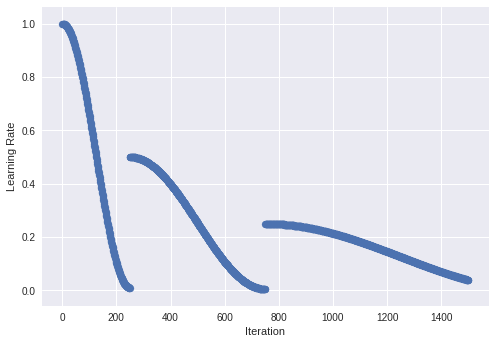

In [59]:
schedule = CyclicalSchedule(CosineAnnealingSchedule, min_lr=lr/100, max_lr=lr,
                            cycle_length=250, cycle_length_decay=2, cycle_magnitude_decay=0.5)
plot_schedule(schedule)

In [0]:


# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=lr,momentum=0.99,wd=0.000001)

updater = mx.optimizer.get_updater(opt)

updater.optimizer.lr_scheduler=schedule

In [0]:
#epoch = 0

In [71]:
epoch_r  =epoch
epoch_r
Es_train=[]
Es_valid=[]
for epoch in range(epoch_r,epoch_r+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    ed={}
    e_key,e_val = e
    for k,v in zip(e_key,e_val):
      ed[k]=v.asnumpy()[0]
    err_train=-ed['dice_coef2']
    err_train2=ed['logloss2']
    
    loss = outputs[1].asnumpy()[0] 
    
    if epoch % 10== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(model_path+prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        Es_valid.append(outputs[1].asnumpy()[0])
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    ed={}
    e_key,e_val = e
    for k,v in zip(e_key,e_val):
      ed[k]=v.asnumpy()[0]
    err_valid=-ed['dice_coef2']
    err_valid2=ed['logloss2']
    

    end = time.time()
    print('time:',end-start,'Epoch:',epoch,"loss",loss,'trainloss:',err_train,'validloss:',err_valid,'trainloss2:',err_train2,'validloss2:',err_valid2)
    myCsvRow = [(epoch,updater.optimizer.lr,loss,err_train,err_valid,err_train2,err_valid2)]
    df = pd.DataFrame.from_records(myCsvRow,columns = col_names)
    df.to_csv(logfile, mode='a', header=False)

/usr/local/lib/python3.6/dist-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


time: 125.79774022102356 Epoch: 0 loss -0.5422351 trainloss: -0.29612347 validloss: -0.27155542 trainloss2: 0.67748696 validloss2: 0.7374362
time: 125.91686296463013 Epoch: 1 loss -0.5125208 trainloss: -0.31362855 validloss: -0.27515602 trainloss2: 0.7345742 validloss2: 0.699784
time: 125.62880229949951 Epoch: 2 loss -0.5353104 trainloss: -0.3341157 validloss: -0.3427159 trainloss2: 0.78395885 validloss2: 0.75479656
time: 125.66213083267212 Epoch: 3 loss -0.45430064 trainloss: -0.33207583 validloss: -0.14881925 trainloss2: 0.7680457 validloss2: 1.3454677
time: 125.59472942352295 Epoch: 4 loss -0.4871722 trainloss: -0.33770406 validloss: -0.278343 trainloss2: 0.8162326 validloss2: 0.98361176
time: 125.51657700538635 Epoch: 5 loss -0.5638607 trainloss: -0.33515006 validloss: -0.27703816 trainloss2: 0.7595156 validloss2: 0.81798136
time: 125.71649050712585 Epoch: 6 loss -0.45615405 trainloss: -0.33633053 validloss: -0.32749096 trainloss2: 0.7438207 validloss2: 0.70035565
time: 125.3289771

In [70]:
!ls "drive/My Drive/x110/model/model10/"

nov8-0000.params  nov8-symbol.json


In [0]:
df = pd.read_csv(logfile, index_col=0)
df.tail()

In [0]:

plt.figure()
plt.plot(df['epoch'],df['lr'])
plt.title('Learning Rate')
plt.figure()
plt.plot(df['epoch'],df['E1train'])
plt.plot(df['epoch'],df['E1valid'],'r')
plt.title('E1')
plt.figure()
plt.plot(df['epoch'],df['E2train'])
plt.plot(df['epoch'],df['E2valid'],'r')
plt.title('E2')

In [0]:
!cp logfile mode_path